GraphRX" methodology: Molecular Encoder + GNN Topology Learning
| Feature | Specification |
| :--- | :--- |
| **Problem Type** | Link Prediction |
| **Classes** | 2 (Binary: safe/interact) |
| **Loss Function** | `BCEWithLogitsLoss` |
| **Architecture** | PyTorch Geometric `GATv2Conv` |
| **Training Edges** | 97,028 positive edges + negatives |
| **Complexity** | Lower |
| **Training Time** | ~15 min for 150 epochs |

```bash
# PyTorch Geometric - LINK PREDICTION
class ModelArchitecture:
    - Uses GATv2Conv (optimized C++ backend)
    - 3 layers: 128 → 64 → 64
    - Dot product decoder: z[src] · z[dst] → probability
    - Binary output: safe (0) or interaction (1)
```

**Why it's fast:**

-  Optimized library - GATv2Conv is highly optimized
- Binary classification - only 2 classes (much simpler)
-  Smaller model - 128→64→64 vs 1032→256→256→128
-  Dot product decoder - simple operation
-  Negative sampling - doesn't process all edges

**Strengths:**

-  Fast training
-  Simple deployment
-  Good for screening (safe vs unsafe)
-  Industry-standard approach

### For EACH epoch:
1. Single forward pass through entire graph (GATv2Conv optimized)
2. Sample negative edges (fast operation)
3. Compute dot products for pos/neg edges
4. Binary loss (BCEWithLogitsLoss)
5. Single backward pass

# Per epoch: 1 pass × optimized ops = FAST

In [29]:
import os
import json
import gc
import random
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.amp import autocast
from torch.cuda.amp import GradScaler
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, roc_auc_score
from torch_geometric.data import Data
from torch_geometric.utils import negative_sampling
from torch_geometric.nn import GATv2Conv, BatchNorm
from torch.utils.checkpoint import checkpoint
from safetensors.torch import save_file
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator
import torch.nn.functional as F
from IPython.display import clear_output
from torch.utils.data import DataLoader, TensorDataset  # NEW

### 2. System Setup

In [30]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"DEVICE: {DEVICE}")
# Memory optimization settings for GPU, Aggressive memory management
if DEVICE.type == 'cuda':
    torch.cuda.empty_cache()
    torch.backends.cudnn.benchmark = True
    torch.backends.cuda.matmul.allow_tf32 = True
    os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
    
    # Force garbage collection
    gc.collect()
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
    print("✓ Memory optimization enabled")

# Force Garbage Collection
print("Cleaning GPU Memory...")
# Delete potential ghost variables if they exist
try:
    del model, optimizer, scaler, z, loss, out
except NameError:
    pass
gc.collect()
#  Clear CUDA Cache
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()    
    # Set Allocator Strategy to reduce fragmentation
    os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'    
    print(f"   GPU Memory Freed. Allocated: {torch.cuda.memory_allocated()/1024**2:.2f} MB")
    print(f"   Reserved: {torch.cuda.memory_reserved()/1024**2:.2f} MB")
else:
    print("   Running on CPU (No CUDA clear needed)")

DEVICE: cuda
GPU: NVIDIA GeForce GTX 1650
GPU Memory: 4.00 GB
✓ Memory optimization enabled
Cleaning GPU Memory...
   GPU Memory Freed. Allocated: 33.19 MB
   Reserved: 70.00 MB


In [31]:
# specific style date time saving
timestamp = datetime.now().strftime("%d_%b_%H-%M")

# validating required directories:
required_directories = ['images', 'models']
for folder in required_directories:
    if not os.path.exists(folder):
        print(f"✘ Directory `{folder}/` not found  Creating...")
        os.makedirs(folder)
    else:
        print(f"✓ Directory `{folder}/` exists ")

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Reproducibility
torch.manual_seed(42)
np.random.seed(42)


✓ Directory `images/` exists 
✓ Directory `models/` exists 


### 2.2 Custom Configurations

### 3. Data Loading Preparation

In [32]:
# Load DDI data
print("Loading data...")
ddi_data = 'dataset/drugdata/ddis.csv'
drug_smiles_data = 'dataset/drugdata/drug_smiles.csv'
if ddi_data and drug_smiles_data:
    print("✓ Data loaded carefully")

print("Data Review:\n")

# Load DDI interactions
ddi_df = pd.read_csv(ddi_data)
print(f"DDI Dataset Shape: {ddi_df.shape}")
print(f"Columns: {ddi_df.columns.tolist()}")
print(f"\n🔬 Interaction Types Distribution:")
print(ddi_df['type'].value_counts())
print(f"\n📋 Sample DDI Data:")
print(ddi_df.head(10))

# Load drug SMILES
smiles_df = pd.read_csv(drug_smiles_data)
print(f"\n💊 Drug SMILES Dataset Shape: {smiles_df.shape}")
print(f"Columns: {smiles_df.columns.tolist()}")
print(f"\n📋 Sample SMILES Data:")
print(smiles_df.head(10))

# Get unique drugs
unique_drugs_ddi = set(ddi_df['d1'].unique()) | set(ddi_df['d2'].unique())
print(f"\n📈 Statistics:")
print(f"• Total DDI pairs: {len(ddi_df)}")
print(f"• Unique drugs in DDI: {len(unique_drugs_ddi)}")
print(f"• Drugs with SMILES: {len(smiles_df)}")
print(f"• Interaction type 0: {(ddi_df['type'] == 0).sum()}")
print(f"• Interaction type 1: {(ddi_df['type'] == 1).sum()}")

# Check overlap
drugs_with_smiles = set(smiles_df['drug_id'].unique())
overlap = unique_drugs_ddi & drugs_with_smiles
print(f"• Drugs with both DDI and SMILES: {len(overlap)}")
print(f"• Coverage: {len(overlap)/len(unique_drugs_ddi)*100:.2f}%")

Loading data...
✓ Data loaded carefully
Data Review:

DDI Dataset Shape: (191808, 4)
Columns: ['d1', 'd2', 'type', 'Neg samples']

🔬 Interaction Types Distribution:
type
48    60751
46    34360
72    23779
74     9470
59     8397
      ...  
42       11
61       11
51       10
25        7
41        6
Name: count, Length: 86, dtype: int64

📋 Sample DDI Data:
        d1       d2  type Neg samples
0  DB04571  DB00460     0   DB01579$t
1  DB00855  DB00460     0   DB01178$t
2  DB09536  DB00460     0   DB06626$t
3  DB01600  DB00460     0   DB01588$t
4  DB09000  DB00460     0   DB06196$t
5  DB11630  DB00460     0   DB00744$t
6  DB00553  DB00460     0   DB06413$t
7  DB06261  DB00460     0   DB00876$t
8  DB01878  DB00460     0   DB09267$t
9  DB00140  DB00460     0   DB01204$t

💊 Drug SMILES Dataset Shape: (1706, 2)
Columns: ['drug_id', 'smiles']

📋 Sample SMILES Data:
   drug_id                                             smiles
0  DB04571                CC1=CC2=CC3=C(OC(=O)C=C3C)C(C)=C2O1
1  D

In [33]:
# Hybrid Model Configuration
CONFIG = {
    'PROJECT_NAME': 'AushadhiNet_GATv2_Hybrid',
    'MODEL_PATH': f'models/AushadhiNet_Hybrid_{timestamp}',    
    
    # Model Hyperparameters
    'NODE_DIM': 128, # 128 or 256
    'HIDDEN_DIM': 64, # 64 or 128 or 256 
    'OUTPUT_DIM': 32,         
    'HEADS': 4,               
    'DROPOUT': 0.3, # 0.3 or 0.2 for more signal pass       
    
    # Training Configuration
    'LR': 0.001,
    'WEIGHT_DECAY': 1e-4,
    'EPOCHS': 150,
    'EDGE_BATCH_SIZE': 4096,
    'GRAD_ACCUM_STEPS': 4,
    
    # Multi-Task Loss Weights
    'BINARY_WEIGHT': 1.0,     # Weight for Safe vs Interaction
    'TYPE_WEIGHT': 0.5,       # Weight for Interaction Type
    
    # Strategy
    'NEG_SAMPLING_RATIO': 1.0,
    
    'DEVICE': torch.device('cuda' if torch.cuda.is_available() else 'cpu')
}

print(f"✓ Configuration loaded: Hybrid Binary + {86} Interaction Types")

✓ Configuration loaded: Hybrid Binary + 86 Interaction Types


### Robust Data Loader (With "Safe" Class Injection)

This is the most important update. It mixes real interactions with generated safe pairs so the model learns the concept of "Safety"

In [34]:
class DataLoader:
    """
    Loads data for hybrid model:
    - Binary labels: Safe (0) vs Interaction (1)
    - Type labels: Which interaction type (0-85) or -1 for safe
    """
    def __init__(self, config):
        self.config = config
        self.drug_map = {} 
        self.type_encoder = LabelEncoder()
        self.fp_gen = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=config['NODE_DIM'])
        self.num_types = 0

    def get_molecular_features(self, smiles):
        try:
            mol = Chem.MolFromSmiles(smiles)
            if mol is None: 
                return np.zeros((self.config['NODE_DIM'],), dtype=np.float32)
            return self.fp_gen.GetFingerprintAsNumPy(mol).astype(np.float32)
        except:
            return np.zeros((self.config['NODE_DIM'],), dtype=np.float32)

    def load_data(self):
        print("📥 Loading Hybrid Data (Binary + Types)...")
        
        ddi_df = pd.read_csv(ddi_data)
        smiles_df = pd.read_csv(drug_smiles_data)
        
        # 1. Build Drug Mapping
        all_drugs = set(ddi_df['d1']).union(set(ddi_df['d2'])).union(set(smiles_df['drug_id']))
        self.drug_map = {d: i for i, d in enumerate(sorted(list(all_drugs)))}
        num_nodes = len(all_drugs)
        
        # 2. Generate Node Features
        print(f"⚗️ Processing {num_nodes} molecular structures...")
        x = np.zeros((num_nodes, self.config['NODE_DIM']), dtype=np.float32)
        smiles_dict = dict(zip(smiles_df.drug_id, smiles_df.smiles))
        
        for drug_id, idx in self.drug_map.items():
            if drug_id in smiles_dict:
                x[idx] = self.get_molecular_features(smiles_dict[drug_id])
        
        x = torch.tensor(x, dtype=torch.float)
        print(f"   ✓ Molecular features: {x.shape}")

        # 3. Encode Interaction Types
        print("🏷️ Encoding Interaction Types...")
        unique_types = sorted(ddi_df['type'].unique())
        self.type_encoder.fit(unique_types)
        self.num_types = len(unique_types)
        
        print(f"   ✓ Found {self.num_types} interaction types: {unique_types[:10]}...")
        
        # 4. Process Positive Edges (Interactions)
        valid_mask = ddi_df['d1'].isin(self.drug_map) & ddi_df['d2'].isin(self.drug_map)
        clean_df = ddi_df[valid_mask].copy()
        
        src_pos = torch.tensor([self.drug_map[d] for d in clean_df['d1']], dtype=torch.long)
        dst_pos = torch.tensor([self.drug_map[d] for d in clean_df['d2']], dtype=torch.long)
        pos_edge_index = torch.stack([src_pos, dst_pos], dim=0)
        
        # Encode types (0 to num_types-1)
        interaction_types = torch.tensor(
            self.type_encoder.transform(clean_df['type']), 
            dtype=torch.long
        )
        
        print(f"   ✓ Positive edges (interactions): {pos_edge_index.size(1)}")
        print(f"   ✓ Type distribution:\n{pd.Series(interaction_types.numpy()).value_counts().head(10)}")

        # 5. Generate Negative Samples (Safe pairs)
        num_pos = pos_edge_index.size(1)
        num_neg = int(num_pos * self.config['NEG_SAMPLING_RATIO'])
        
        print(f"🛡️ Sampling {num_neg} safe (negative) pairs...")
        neg_edge_index = negative_sampling(
            edge_index=pos_edge_index,
            num_nodes=num_nodes,
            num_neg_samples=num_neg,
            method='sparse'
        )

        # 6. Combine Edges with Dual Labels
        edge_index = torch.cat([pos_edge_index, neg_edge_index], dim=1)
        
        # Binary labels (0=Safe, 1=Interaction)
        y_binary = torch.cat([
            torch.ones(num_pos, dtype=torch.long),   # Interactions
            torch.zeros(num_neg, dtype=torch.long)   # Safe
        ])
        
        # Type labels (-1 for safe, 0-85 for interaction types)
        y_type = torch.cat([
            interaction_types,                       # Real types
            torch.full((num_neg,), -1, dtype=torch.long)  # -1 = Safe (no type)
        ])
        
        # 7. Shuffle
        perm = torch.randperm(edge_index.size(1))
        edge_index = edge_index[:, perm]
        y_binary = y_binary[perm]
        y_type = y_type[perm]

        print(f"\n✓ Dataset Summary:")
        print(f"   Total edges: {edge_index.size(1)}")
        print(f"   Safe edges: {(y_binary == 0).sum().item()}")
        print(f"   Interaction edges: {(y_binary == 1).sum().item()}")
        print(f"   Unique interaction types: {self.num_types}")

        # Create Data object with dual labels
        data = Data(x=x, edge_index=edge_index)
        data.y_binary = y_binary
        data.y_type = y_type
        
        return data, self.drug_map, self.num_types, self.type_encoder

# Load Data
print("="*70)
loader = DataLoader(CONFIG)
data, drug_map, num_types, type_encoder = loader.load_data()
print("="*70)

📥 Loading Hybrid Data (Binary + Types)...
⚗️ Processing 1706 molecular structures...
   ✓ Molecular features: torch.Size([1706, 128])
🏷️ Encoding Interaction Types...
   ✓ Found 86 interaction types: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9)]...
   ✓ Positive edges (interactions): 191808
   ✓ Type distribution:
48    60751
46    34360
72    23779
74     9470
59     8397
69     7786
19     6140
15     5413
3      5011
5      3160
Name: count, dtype: int64
🛡️ Sampling 191808 safe (negative) pairs...

✓ Dataset Summary:
   Total edges: 383616
   Safe edges: 191808
   Interaction edges: 191808
   Unique interaction types: 86


### Architecture (GATv2 + Multiclass Decoder)

Uses GATv2 for topology learning and an MLP decoder to classify the interaction type.

In [35]:
class GATv2Net_Hybrid(torch.nn.Module):
    """
    Hybrid GATv2 Network for Drug-Drug Interaction Prediction
    
    Outputs:
    1. Binary: Safe (0) vs Interaction (1)
    2. Type: Which interaction type (0-85) if interaction detected
    """
    def __init__(self, in_dim, hidden_dim, out_dim, num_types, heads=4, dropout=0.3):
        super().__init__()
        
        print(f"🏗️ Building Hybrid Model:")
        print(f"   Node Features: {in_dim}")
        print(f"   Hidden Dim: {hidden_dim}")
        print(f"   Output Embedding: {out_dim}")
        print(f"   Interaction Types: {num_types}")
        print(f"   Attention Heads: {heads}")
        
        # --- Shared Encoder (GATv2) ---
        self.conv1 = GATv2Conv(in_dim, hidden_dim, heads=heads, dropout=dropout, concat=True)
        self.bn1 = BatchNorm(hidden_dim * heads)
        
        self.conv2 = GATv2Conv(hidden_dim * heads, out_dim, heads=1, dropout=dropout, concat=False)
        self.bn2 = BatchNorm(out_dim)
        
        self.skip = torch.nn.Linear(in_dim, out_dim)
        self.dropout = dropout
        
        # --- Task 1: Binary Decoder (Safe vs Interaction) ---
        self.binary_decoder = torch.nn.Sequential(
            torch.nn.Linear(out_dim * 2, hidden_dim),
            torch.nn.BatchNorm1d(hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout),
            torch.nn.Linear(hidden_dim, hidden_dim // 2),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim // 2, 1)  # Binary output
        )
        
        # --- Task 2: Type Decoder (Interaction Classification) ---
        self.type_decoder = torch.nn.Sequential(
            torch.nn.Linear(out_dim * 2, hidden_dim),
            torch.nn.BatchNorm1d(hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout),
            torch.nn.Linear(hidden_dim, hidden_dim // 2),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim // 2, num_types)  # Multi-class output
        )

    def encode(self, x, edge_index):
        """Shared graph encoding"""
        identity = self.skip(x)
        
        # Layer 1
        h = self.conv1(x, edge_index)
        h = self.bn1(h)
        h = F.elu(h)
        h = F.dropout(h, p=self.dropout, training=self.training)
        
        # Layer 2
        h = self.conv2(h, edge_index)
        h = self.bn2(h)
        
        return h + identity

    def decode(self, z, edge_index):
        """Dual decoding: Binary + Type"""
        src = z[edge_index[0]]
        dst = z[edge_index[1]]
        edge_emb = torch.cat([src, dst], dim=1)
        
        binary_logits = self.binary_decoder(edge_emb).squeeze(-1)
        type_logits = self.type_decoder(edge_emb)
        
        return binary_logits, type_logits

    def forward(self, x, edge_index):
        z = self.encode(x, edge_index)
        return self.decode(z, edge_index)

# Initialize Model
model = GATv2Net_Hybrid(
    in_dim=CONFIG['NODE_DIM'],
    hidden_dim=CONFIG['HIDDEN_DIM'],
    out_dim=CONFIG['OUTPUT_DIM'],
    num_types=num_types,
    heads=CONFIG['HEADS'],
    dropout=CONFIG['DROPOUT']
).to(CONFIG['DEVICE'])

total_params = sum(p.numel() for p in model.parameters())
print(f"\n✓ Model initialized: {total_params:,} parameters")
print(f"✓ Binary decoder: {sum(p.numel() for p in model.binary_decoder.parameters()):,} params")
print(f"✓ Type decoder: {sum(p.numel() for p in model.type_decoder.parameters()):,} params")

🏗️ Building Hybrid Model:
   Node Features: 128
   Hidden Dim: 64
   Output Embedding: 32
   Interaction Types: 86
   Attention Heads: 4

✓ Model initialized: 103,383 parameters
✓ Binary decoder: 6,401 params
✓ Type decoder: 9,206 params


In [36]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

def plot_training_progress(history, epoch, CONFIG, best_val_auc,
                           train_loss_total, train_acc_binary, train_acc_type,
                           val_loss_total, val_acc_binary, val_acc_type, val_auc,
                           current_lr):
    """
    2-column x 3-row live training visualization + text summary
    """
    clear_output(wait=True)

    fig, axes = plt.subplots(3, 2, figsize=(18, 14))
    plt.subplots_adjust(hspace=0.35, wspace=0.25)

    # ── Row 1 ── Losses
    axes[0, 0].plot(history['epoch'], history['train_loss_total'], 'b-o', label='Train', markersize=3)
    axes[0, 0].plot(history['epoch'], history['val_loss_total'], 'r-o', label='Val', markersize=3)
    axes[0, 0].set_title('Total Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(alpha=0.3)

    axes[0, 1].plot(history['epoch'], history['train_loss_binary'], 'b-o', label='Train', markersize=3)
    axes[0, 1].plot(history['epoch'], history['val_loss_binary'], 'r-o', label='Val', markersize=3)
    axes[0, 1].set_title('Binary Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(alpha=0.3)

    # ── Row 2 ── More losses + accuracy
    axes[1, 0].plot(history['epoch'], history['train_loss_type'], 'b-o', label='Train', markersize=3)
    axes[1, 0].plot(history['epoch'], history['val_loss_type'], 'r-o', label='Val', markersize=3)
    axes[1, 0].set_title('Type Loss')
    axes[1, 0].legend()
    axes[1, 0].grid(alpha=0.3)

    axes[1, 1].plot(history['epoch'], history['train_acc_binary'], 'b-o', label='Train', markersize=3)
    axes[1, 1].plot(history['epoch'], history['val_acc_binary'], 'g-o', label='Val', markersize=3)
    axes[1, 1].set_title(f'Binary Accuracy (Val: {val_acc_binary:.2%})', fontsize=12,fontweight='bold')
    axes[1, 1].set_ylim(0, 1)
    axes[1, 1].legend()
    axes[1, 1].grid(alpha=0.3)

    # ── Row 3 ── Type accuracy + AUC
    axes[2, 0].plot(history['epoch'], history['train_acc_type'], 'b-o', label='Train', markersize=3)
    axes[2, 0].plot(history['epoch'], history['val_acc_type'], 'purple', marker='o', label='Val', markersize=3)
    axes[2, 0].set_title(f'Type Accuracy (Val: {val_acc_type:.2%})')
    axes[2, 0].set_ylim(0, 1)
    axes[2, 0].legend()
    axes[2, 0].grid(alpha=0.3)

    axes[2, 1].plot(history['epoch'], history['val_auc'], 'orange', marker='o', markersize=3)
    axes[2, 1].axhline(best_val_auc, color='red', linestyle='--',
                       label=f'Best: {best_val_auc:.4f}')
    axes[2, 1].set_title(f'AUC-ROC (Current: {val_auc:.4f})')
    axes[2, 1].set_ylim(0.5, 1.0)
    axes[2, 1].legend()
    axes[2, 1].grid(alpha=0.3)

    plt.suptitle(
        'Hybrid Model Training - Drug-Drug Interaction Prediction',
        fontsize=16, fontweight='bold'
    )
    plt.show()

    # ── Text summary (outside plot)
    print(f"""
══════════════════════════════════════════════════════════════════════
EPOCH {epoch:03d}/{CONFIG['EPOCHS']} SUMMARY
──────────────────────────────────────────────────────────────────────
TRAINING
  • Total Loss   : {train_loss_total:.4f}
  • Binary Acc   : {train_acc_binary:.2%}
  • Type Acc     : {train_acc_type:.2%}

VALIDATION
  • Total Loss   : {val_loss_total:.4f}
  • Binary Acc   : {val_acc_binary:.2%}
  • Type Acc     : {val_acc_type:.2%}
  • AUC-ROC      : {val_auc:.4f}

OPTIMIZATION
  • Learning Rate: {current_lr:.2e}
  • Best AUC     : {best_val_auc:.4f}
══════════════════════════════════════════════════════════════════════
""")

### Training Loop (With Live Visualization)

Standard CrossEntropy training with a live refreshing plot to monitor convergence.

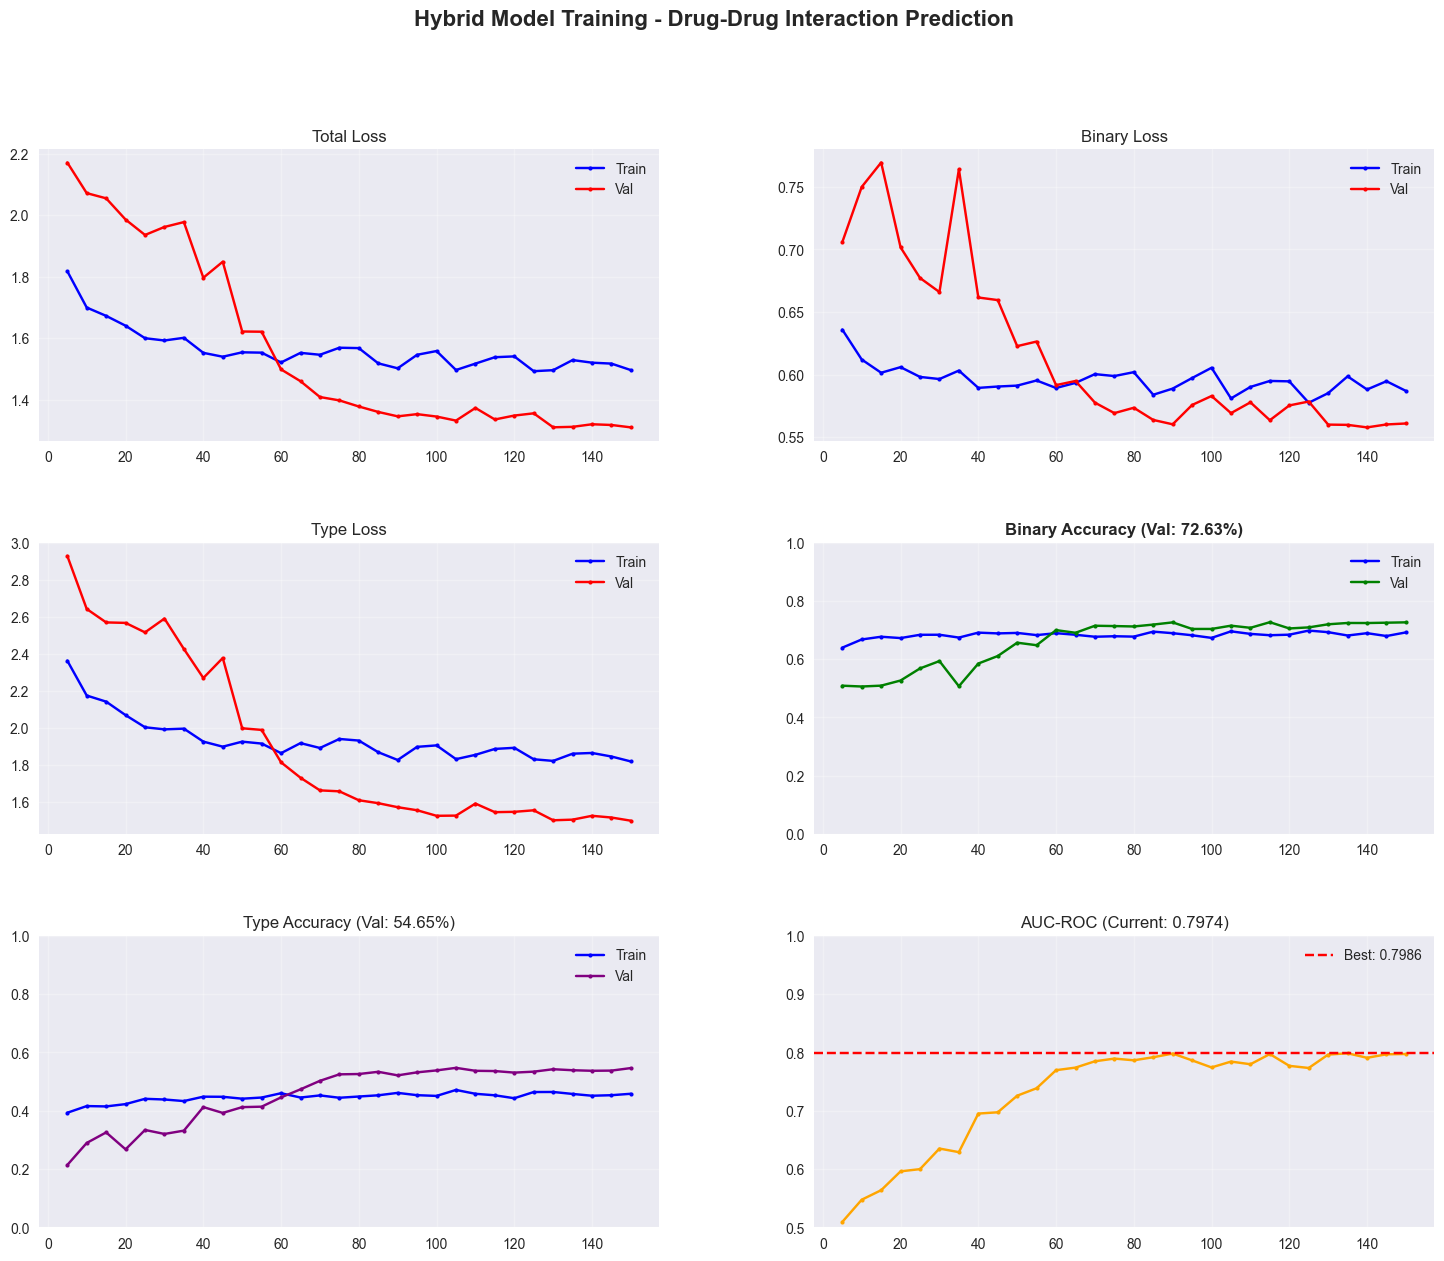


══════════════════════════════════════════════════════════════════════
EPOCH 150/150 SUMMARY
──────────────────────────────────────────────────────────────────────
TRAINING
  • Total Loss   : 1.4959
  • Binary Acc   : 69.18%
  • Type Acc     : 45.83%

VALIDATION
  • Total Loss   : 1.3096
  • Binary Acc   : 72.63%
  • Type Acc     : 54.65%
  • AUC-ROC      : 0.7974

OPTIMIZATION
  • Learning Rate: 1.00e-03
  • Best AUC     : 0.7986
══════════════════════════════════════════════════════════════════════


✅ Training Complete!
🏆 Best Validation AUC: 0.7986


In [37]:
# Training Setup
optimizer = torch.optim.AdamW(model.parameters(), lr=CONFIG['LR'], weight_decay=CONFIG['WEIGHT_DECAY'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=10)
scaler = GradScaler()

# Loss Functions
binary_criterion = torch.nn.BCEWithLogitsLoss()
type_criterion = torch.nn.CrossEntropyLoss(ignore_index=-1)  # Ignore safe edges (-1)

# Data Splits
num_edges = data.edge_index.size(1)
perm = torch.randperm(num_edges)
train_size = int(0.8 * num_edges)
val_size = int(0.9 * num_edges)

train_idx = perm[:train_size]
val_idx = perm[train_size:val_size]
test_idx = perm[val_size:]

print(f"📊 Data Split: Train={len(train_idx)}, Val={len(val_idx)}, Test={len(test_idx)}")

# Edge Batching
def create_edge_batches(edge_index, binary_labels, type_labels, batch_size):
    num_edges = edge_index.size(1)
    indices = torch.randperm(num_edges)
    
    for start in range(0, num_edges, batch_size):
        end = min(start + batch_size, num_edges)
        batch_indices = indices[start:end]
        yield (edge_index[:, batch_indices], 
               binary_labels[batch_indices], 
               type_labels[batch_indices])

# Training History
history = {
    'epoch': [],
    'train_loss_total': [], 'train_loss_binary': [], 'train_loss_type': [],
    'train_acc_binary': [], 'train_acc_type': [],
    'val_loss_total': [], 'val_loss_binary': [], 'val_loss_type': [],
    'val_acc_binary': [], 'val_acc_type': [], 'val_auc': [],
    'learning_rate': []
}
best_val_auc = 0

print(f"\n🚀 Starting Hybrid Training on {CONFIG['DEVICE']}...")
print(f"   Task 1: Binary Classification (Safe vs Interaction)")
print(f"   Task 2: Type Classification ({num_types} types)")
print(f"   Loss Weights: Binary={CONFIG['BINARY_WEIGHT']}, Type={CONFIG['TYPE_WEIGHT']}\n")

for epoch in range(1, CONFIG['EPOCHS'] + 1):
    model.train()
    
    # Metrics tracking
    train_losses_total, train_losses_binary, train_losses_type = [], [], []
    train_preds_binary, train_labels_binary = [], []
    train_preds_type, train_labels_type = [], []
    
    # Clear cache
    if CONFIG['DEVICE'].type == 'cuda':
        torch.cuda.empty_cache()
    
    # Encode graph once
    with torch.no_grad():
        z = model.encode(data.x.to(CONFIG['DEVICE']), data.edge_index.to(CONFIG['DEVICE']))
    z.requires_grad = True
    
    # Prepare training data
    train_edges = data.edge_index[:, train_idx]
    train_binary = data.y_binary[train_idx].float()
    train_types = data.y_type[train_idx]
    
    optimizer.zero_grad()
    
    for batch_idx, (edge_batch, binary_batch, type_batch) in enumerate(
        create_edge_batches(train_edges, train_binary, train_types, CONFIG['EDGE_BATCH_SIZE'])
    ):
        edge_batch = edge_batch.to(CONFIG['DEVICE'])
        binary_batch = binary_batch.to(CONFIG['DEVICE'])
        type_batch = type_batch.to(CONFIG['DEVICE'])
        
        with autocast(device_type='cuda' if CONFIG['DEVICE'].type == 'cuda' else 'cpu'):
            binary_logits, type_logits = model.decode(z, edge_batch)
            
            # Binary loss
            loss_binary = binary_criterion(binary_logits, binary_batch)
            
            # Type loss (only for interactions, not safe edges)
            loss_type = type_criterion(type_logits, type_batch)
            
            # Combined loss
            loss_total = (CONFIG['BINARY_WEIGHT'] * loss_binary + 
                         CONFIG['TYPE_WEIGHT'] * loss_type) / CONFIG['GRAD_ACCUM_STEPS']
        
        scaler.scale(loss_total).backward()
        
        if (batch_idx + 1) % CONFIG['GRAD_ACCUM_STEPS'] == 0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
        
        # Track metrics
        train_losses_total.append(loss_total.item() * CONFIG['GRAD_ACCUM_STEPS'])
        train_losses_binary.append(loss_binary.item())
        train_losses_type.append(loss_type.item())
        
        with torch.no_grad():
            # Binary predictions
            binary_preds = (torch.sigmoid(binary_logits) > 0.5).float()
            train_preds_binary.extend(binary_preds.cpu().numpy())
            train_labels_binary.extend(binary_batch.cpu().numpy())
            
            # Type predictions (only for interactions)
            interaction_mask = binary_batch == 1
            if interaction_mask.any():
                type_preds = type_logits[interaction_mask].argmax(dim=1)
                train_preds_type.extend(type_preds.cpu().numpy())
                train_labels_type.extend(type_batch[interaction_mask].cpu().numpy())
    
    # Calculate training metrics
    train_loss_total = np.mean(train_losses_total)
    train_loss_binary = np.mean(train_losses_binary)
    train_loss_type = np.mean(train_losses_type)
    train_acc_binary = accuracy_score(train_labels_binary, train_preds_binary)
    train_acc_type = accuracy_score(train_labels_type, train_preds_type) if len(train_labels_type) > 0 else 0.0
    
    # VALIDATION
    if epoch % 5 == 0:
        model.eval()
        with torch.no_grad():
            z_val = model.encode(data.x.to(CONFIG['DEVICE']), data.edge_index.to(CONFIG['DEVICE']))
            
            val_edges = data.edge_index[:, val_idx].to(CONFIG['DEVICE'])
            val_binary = data.y_binary[val_idx].float().to(CONFIG['DEVICE'])
            val_types = data.y_type[val_idx].to(CONFIG['DEVICE'])
            
            binary_logits, type_logits = model.decode(z_val, val_edges)
            
            # Losses
            loss_binary = binary_criterion(binary_logits, val_binary).item()
            loss_type = type_criterion(type_logits, val_types).item()
            loss_total = CONFIG['BINARY_WEIGHT'] * loss_binary + CONFIG['TYPE_WEIGHT'] * loss_type
            
            # Binary metrics
            val_probs = torch.sigmoid(binary_logits).cpu().numpy()
            val_preds_binary = (val_probs > 0.5).astype(int)
            val_labels_binary = val_binary.cpu().numpy()
            
            val_acc_binary = accuracy_score(val_labels_binary, val_preds_binary)
            val_auc = roc_auc_score(val_labels_binary, val_probs)
            
            # Type metrics (only for interactions)
            interaction_mask = val_binary == 1
            if interaction_mask.any():
                type_preds = type_logits[interaction_mask].argmax(dim=1).cpu().numpy()
                type_labels = val_types[interaction_mask].cpu().numpy()
                val_acc_type = accuracy_score(type_labels, type_preds)
            else:
                val_acc_type = 0.0
        
        # Update history
        current_lr = optimizer.param_groups[0]['lr']
        history['epoch'].append(epoch)
        history['train_loss_total'].append(train_loss_total)
        history['train_loss_binary'].append(train_loss_binary)
        history['train_loss_type'].append(train_loss_type)
        history['train_acc_binary'].append(train_acc_binary)
        history['train_acc_type'].append(train_acc_type)
        history['val_loss_total'].append(loss_total)
        history['val_loss_binary'].append(loss_binary)
        history['val_loss_type'].append(loss_type)
        history['val_acc_binary'].append(val_acc_binary)
        history['val_acc_type'].append(val_acc_type)
        history['val_auc'].append(val_auc)
        history['learning_rate'].append(current_lr)
        
        scheduler.step(val_auc)
        
        # Save best model
        if val_auc > best_val_auc:
            best_val_auc = val_auc
            torch.save(model.state_dict(), f"{CONFIG['MODEL_PATH']}_best.pth")
            print(f"💾 New best model! (AUC: {val_auc:.4f}, Type Acc: {val_acc_type:.2%})")
        
        # Visualization
        plot_training_progress(
            history=history,
            epoch=epoch,
            CONFIG=CONFIG,
            best_val_auc=best_val_auc,
            train_loss_total=train_loss_total,
            train_acc_binary=train_acc_binary,
            train_acc_type=train_acc_type,
            val_loss_total=loss_total,
            val_acc_binary=val_acc_binary,
            val_acc_type=val_acc_type,
            val_auc=val_auc,
            current_lr=current_lr
        )
print("\n✅ Training Complete!")
print(f"🏆 Best Validation AUC: {best_val_auc:.4f}")

✅ Properly trained
✅ Not overfitting
⚠️ Slightly underfitting (especially the type task)
✅ Binary task is solid
⚠️ Type classification is the bottleneck

### Evaluation & Saving

Saves the model in safetensors format along with the critical JSON mapping for the "Safe" class.

🏆 Final Hybrid Model Evaluation...

                    📊 FINAL TEST RESULTS (HYBRID MODEL)

🔵 TASK 1: BINARY CLASSIFICATION (Safe vs Interaction)
   Accuracy:  0.7233 (72.33%)
   F1-Score:  0.7349
   AUC-ROC:   0.7988

🟣 TASK 2: TYPE CLASSIFICATION (Interaction Types)
   Accuracy:  0.5402 (54.02%)
   F1-Score:  0.4794
   Test on:   19,157 interaction edges

📋 Binary Classification Report:
                 precision    recall  f1-score   support

       Safe (0)     0.7458    0.6787    0.7107     19205
Interaction (1)     0.7046    0.7681    0.7349     19157

       accuracy                         0.7233     38362
      macro avg     0.7252    0.7234    0.7228     38362
   weighted avg     0.7252    0.7233    0.7228     38362



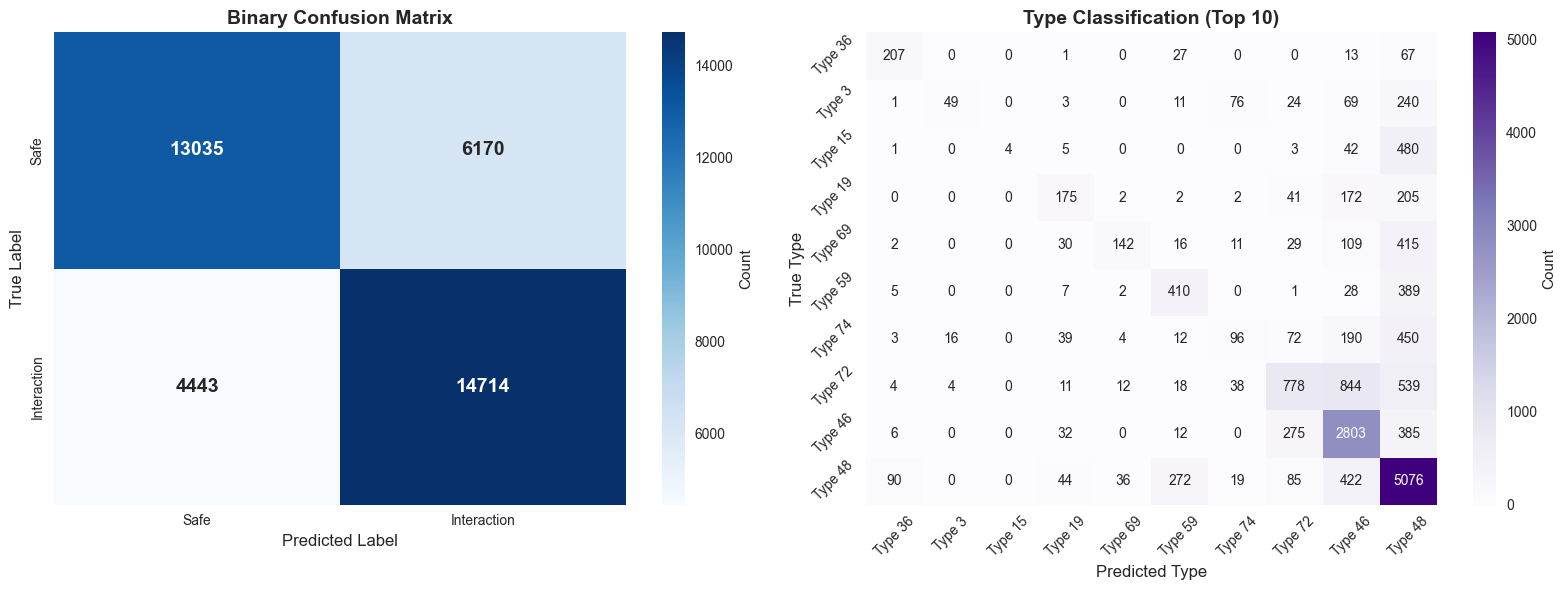


📊 Top-10 Type Classification Performance:
   Type  48: 83.43% accuracy (6,084 samples)
   Type  46: 79.77% accuracy (3,514 samples)
   Type  72: 34.35% accuracy (2,265 samples)
   Type  74: 10.53% accuracy (912 samples)
   Type  59: 48.41% accuracy (847 samples)
   Type  69: 18.61% accuracy (763 samples)
   Type  19: 29.17% accuracy (600 samples)
   Type  15: 0.75% accuracy (535 samples)
   Type   3: 10.21% accuracy (480 samples)
   Type  36: 65.71% accuracy (315 samples)


In [41]:
# Load best model
model.load_state_dict(torch.load(f"{CONFIG['MODEL_PATH']}_best.pth"))
model.eval()

print("🏆 Final Hybrid Model Evaluation...")
with torch.no_grad():
    z_test = model.encode(data.x.to(CONFIG['DEVICE']), data.edge_index.to(CONFIG['DEVICE']))
    
    test_edges = data.edge_index[:, test_idx].to(CONFIG['DEVICE'])
    test_binary = data.y_binary[test_idx].float().to(CONFIG['DEVICE'])
    test_types = data.y_type[test_idx].to(CONFIG['DEVICE'])
    
    binary_logits, type_logits = model.decode(z_test, test_edges)
    
    # Binary predictions
    test_probs = torch.sigmoid(binary_logits).cpu().numpy()
    test_preds_binary = (test_probs > 0.5).astype(int)
    test_labels_binary = test_binary.cpu().numpy()
    
    # Type predictions (only for interactions)
    interaction_mask = test_binary == 1
    if interaction_mask.any():
        type_preds = type_logits[interaction_mask].argmax(dim=1).cpu().numpy()
        type_labels = test_types[interaction_mask].cpu().numpy()
    else:
        type_preds, type_labels = np.array([]), np.array([])

# Binary metrics
binary_acc = accuracy_score(test_labels_binary, test_preds_binary)
binary_f1 = f1_score(test_labels_binary, test_preds_binary)
binary_auc = roc_auc_score(test_labels_binary, test_probs)

# Type metrics
type_acc = accuracy_score(type_labels, type_preds) if len(type_labels) > 0 else 0.0
type_f1 = f1_score(type_labels, type_preds, average='weighted') if len(type_labels) > 0 else 0.0

# Display results
print("\n" + "="*80)
print("                    📊 FINAL TEST RESULTS (HYBRID MODEL)")
print("="*80)
print("\n🔵 TASK 1: BINARY CLASSIFICATION (Safe vs Interaction)")
print(f"   Accuracy:  {binary_acc:.4f} ({binary_acc*100:.2f}%)")
print(f"   F1-Score:  {binary_f1:.4f}")
print(f"   AUC-ROC:   {binary_auc:.4f}")
print("\n🟣 TASK 2: TYPE CLASSIFICATION (Interaction Types)")
print(f"   Accuracy:  {type_acc:.4f} ({type_acc*100:.2f}%)")
print(f"   F1-Score:  {type_f1:.4f}")
print(f"   Test on:   {len(type_labels):,} interaction edges")
print("="*80)

# Binary Confusion Matrix
print("\n📋 Binary Classification Report:")
print(classification_report(test_labels_binary, test_preds_binary, 
                          target_names=['Safe (0)', 'Interaction (1)'], digits=4))

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Binary CM
cm_binary = confusion_matrix(test_labels_binary, test_preds_binary)
sns.heatmap(cm_binary, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Safe', 'Interaction'], 
            yticklabels=['Safe', 'Interaction'],
            cbar_kws={'label': 'Count'},
            annot_kws={'fontsize': 14, 'fontweight': 'bold'})
axes[0].set_title('Binary Confusion Matrix', fontsize=14, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].set_xlabel('Predicted Label', fontsize=12)

# Type CM (top 10 classes)
if len(type_labels) > 0:
    # Get top 10 most common types
    unique_types, counts = np.unique(type_labels, return_counts=True)
    top_10_indices = np.argsort(counts)[-10:]
    top_10_types = unique_types[top_10_indices]
    
    # Filter predictions for top 10
    mask = np.isin(type_labels, top_10_types)
    cm_type = confusion_matrix(type_labels[mask], type_preds[mask], labels=top_10_types)
    
    # Get original type names
    type_names = [f"Type {type_encoder.inverse_transform([t])[0]}" for t in top_10_types]
    
    sns.heatmap(cm_type, annot=True, fmt='d', cmap='Purples', ax=axes[1],
                xticklabels=type_names, yticklabels=type_names,
                cbar_kws={'label': 'Count'})
    axes[1].set_title('Type Classification (Top 10)', fontsize=14, fontweight='bold')
    axes[1].set_ylabel('True Type', fontsize=12)
    axes[1].set_xlabel('Predicted Type', fontsize=12)
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].tick_params(axis='y', rotation=45)

plt.tight_layout()
plt.savefig(f"images/hybrid_confusion_matrix_{timestamp}.png", dpi=300, bbox_inches='tight')
plt.show()

# Top-5 Type Accuracy
print("\n📊 Top-10 Type Classification Performance:")
if len(type_labels) > 0:
    for i, type_idx in enumerate(top_10_types[::-1][:10]):  # Reverse to show most common first
        original_type = type_encoder.inverse_transform([type_idx])[0]
        mask = type_labels == type_idx
        if mask.sum() > 0:
            acc = accuracy_score(type_labels[mask], type_preds[mask])
            count = mask.sum()
            print(f"   Type {original_type:3d}: {acc:.2%} accuracy ({count:,} samples)")

In [42]:
# Save final model
os.makedirs(os.path.dirname(CONFIG['MODEL_PATH']), exist_ok=True)

# Safetensors format
tensor_path = f"{CONFIG['MODEL_PATH']}_final.safetensors"
save_file(model.state_dict(), tensor_path)
print(f"💾 Model saved: {tensor_path}")

# Metadata with type mapping
metadata = {
    'config': {k: str(v) for k, v in CONFIG.items()},
    'drug_map': drug_map,
    'num_drugs': len(drug_map),
    'num_types': int(num_types),
    'type_encoder_classes': type_encoder.classes_.tolist(),
    'type_mapping': {
        int(i): int(type_encoder.inverse_transform([i])[0]) 
        for i in range(num_types)
    },
    'task': 'hybrid_binary_and_type',
    'performance': {
        'binary_accuracy': float(binary_acc),
        'binary_f1': float(binary_f1),
        'binary_auc': float(binary_auc),
        'type_accuracy': float(type_acc),
        'type_f1': float(type_f1)
    }
}

json_path = f"{CONFIG['MODEL_PATH']}_metadata.json"
with open(json_path, 'w') as f:
    json.dump(metadata, f, indent=4)
print(f"📜 Metadata saved: {json_path}")

# Save training history
history_df = pd.DataFrame(history)
history_df.to_csv(f"{CONFIG['MODEL_PATH']}_history.csv", index=False)
print(f"📈 Training history saved: {CONFIG['MODEL_PATH']}_history.csv")

💾 Model saved: models/AushadhiNet_Hybrid_10_Feb_23-45_final.safetensors
📜 Metadata saved: models/AushadhiNet_Hybrid_10_Feb_23-45_metadata.json
📈 Training history saved: models/AushadhiNet_Hybrid_10_Feb_23-45_history.csv


### Professional Inference Function

This logic correctly handles the new "Safe" class during prediction.

In [43]:
def predict_drug_interaction(drug_a_id, drug_b_id, threshold=0.5):
    """
    Predict drug-drug interaction with type classification
    
    Returns:
    {
        "drug_pair": "DB00001 + DB00002",
        "status": "Safe" or "Interaction Detected",
        "binary_probability": "92.3%",
        "confidence": "92.3%",
        "interaction_type": "Type 48",
        "type_probability": "78.5%",
        "type_confidence": "78.5%",
        "recommendation": "..."
    }
    """
    model.eval()
    
    # Validation
    if drug_a_id not in drug_map:
        return {"error": f"Unknown drug ID: {drug_a_id}"}
    if drug_b_id not in drug_map:
        return {"error": f"Unknown drug ID: {drug_b_id}"}
    
    idx_a = drug_map[drug_a_id]
    idx_b = drug_map[drug_b_id]
    edge = torch.tensor([[idx_a], [idx_b]], dtype=torch.long).to(CONFIG['DEVICE'])
    
    with torch.no_grad():
        # Encode graph
        z = model.encode(data.x.to(CONFIG['DEVICE']), data.edge_index.to(CONFIG['DEVICE']))
        
        # Get predictions
        binary_logit, type_logits = model.decode(z, edge)
        
        # Binary prediction
        binary_prob = torch.sigmoid(binary_logit).item()
        is_interaction = binary_prob > threshold
        
        # Type prediction (if interaction)
        if is_interaction:
            type_probs = F.softmax(type_logits, dim=1)[0]
            type_pred_idx = type_probs.argmax().item()
            type_prob = type_probs[type_pred_idx].item()
            
            # Map back to original type
            original_type = type_encoder.inverse_transform([type_pred_idx])[0]
        else:
            type_prob = 0.0
            original_type = None
    
    # Build response
    result = {
        "drug_pair": f"{drug_a_id} + {drug_b_id}",
        "status": "⚠️ INTERACTION DETECTED" if is_interaction else "✅ SAFE",
        "binary_probability": f"{binary_prob:.2%}",
        "binary_confidence": f"{max(binary_prob, 1-binary_prob):.2%}",
    }
    
    if is_interaction:
        result.update({
            "interaction_type": f"Type {original_type}",
            "type_probability": f"{type_prob:.2%}",
            "type_confidence": f"{type_prob:.2%}",
            "recommendation": "⚠️ Consult physician before co-administration"
        })
    else:
        result.update({
            "interaction_type": "None",
            "type_probability": "N/A",
            "type_confidence": "N/A",
            "recommendation": "✅ No known significant interaction"
        })
    
    return result

# Test with multiple pairs
print("🔮 Testing Hybrid Inference...\n")
print("="*80)

# Test 1: Random pair
test_drugs = list(drug_map.keys())
drug_a = test_drugs[0]
drug_b = test_drugs[50]

result = predict_drug_interaction(drug_a, drug_b)
print(json.dumps(result, indent=2))

print("\n" + "="*80)

# Test 2: Known interaction (if available)
if len(test_drugs) > 100:
    drug_c = test_drugs[10]
    drug_d = test_drugs[100]
    
    result2 = predict_drug_interaction(drug_c, drug_d)
    print(json.dumps(result2, indent=2))
    print("\n" + "="*80)

print("\n✅ Hybrid model ready for deployment!")

🔮 Testing Hybrid Inference...

{
  "drug_pair": "DB00006 + DB00203",
  "status": "\u26a0\ufe0f INTERACTION DETECTED",
  "binary_probability": "85.37%",
  "binary_confidence": "85.37%",
  "interaction_type": "Type 72",
  "type_probability": "52.09%",
  "type_confidence": "52.09%",
  "recommendation": "\u26a0\ufe0f Consult physician before co-administration"
}

{
  "drug_pair": "DB00126 + DB00255",
  "status": "\u2705 SAFE",
  "binary_probability": "33.24%",
  "binary_confidence": "66.76%",
  "interaction_type": "None",
  "type_probability": "N/A",
  "type_confidence": "N/A",
  "recommendation": "\u2705 No known significant interaction"
}


✅ Hybrid model ready for deployment!
